In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uqq duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
spacy 3.3.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.3.0 which is incompatible.
ray 2.0.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images = 150):
    print(f'Searching for {term}.')
    return L(ddg_images(term, max_results = max_images)).itemgot('image')

In [4]:
urls = search_images('grizzly bear', max_images = 1)
print(len(urls))
urls[0]

Searching for grizzly bear.
1


'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg'

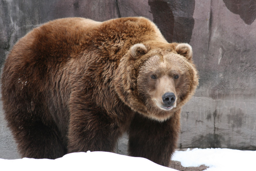

In [5]:
from fastdownload import download_url
dest = 'grizzly.jpg'
download_url(urls[0], dest, show_progress = True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Searching for black bear.


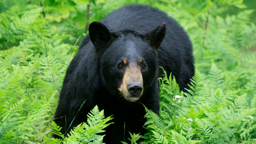

In [6]:
download_url(search_images('black bear', max_images = 1)[0], 'black.jpg', show_progress = True)
Image.open('black.jpg').to_thumb(256, 256)

Searching for teddy bear.


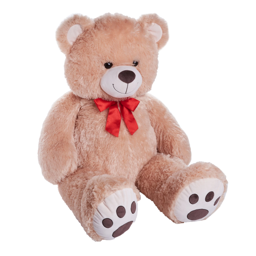

In [7]:
download_url(search_images('teddy bear', max_images = 1)[0], 'teddy.jpg', show_progress = True)
Image.open('teddy.jpg').to_thumb(256, 256)

In [8]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bear_identify')
from time import sleep

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok = True, parents = True)
    download_images(dest, urls = search_images(f'{o} bear photos'))
    sleep(5)
    print(f"resizing {o} photos")
    resize_images(path/o, max_size = 224, dest=path/o)

Searching for grizzly bear photos.
resizing grizzly photos
Searching for black bear photos.
resizing black photos
Searching for teddy bear photos.
resizing teddy photos


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

In [10]:
dls = DataBlock(
blocks = (ImageBlock, CategoryBlock),
get_items = get_image_files,
splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
get_y = parent_label,
item_tfms = RandomResizedCrop(224, min_scale = 0.5),
batch_tfms = aug_transforms()
).dataloaders(path)

In [11]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(15)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.515913,0.183332,0.070588,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.264411,0.074767,0.023529,00:02
1,0.210341,0.034564,0.011765,00:02
2,0.166997,0.017744,0.000000,00:02
3,0.131387,0.015749,0.000000,00:02
4,0.112155,0.020824,0.011765,00:03
5,0.092113,0.007708,0.000000,00:02
6,0.075965,0.002993,0.000000,00:02
7,0.064375,0.002561,0.000000,00:02
8,0.054840,0.001953,0.000000,00:02
9,0.051853,0.004230,0.000000,00:02


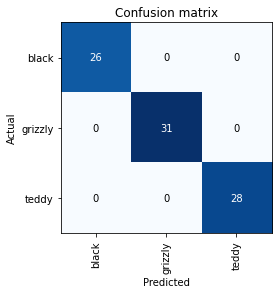

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

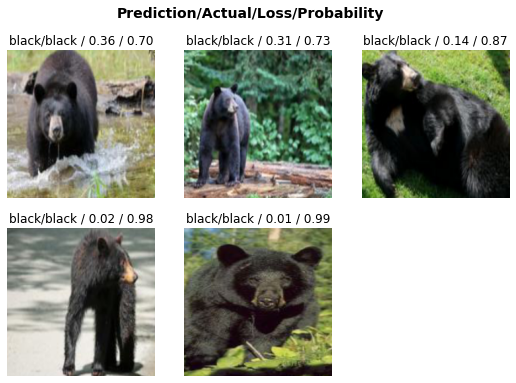

In [13]:
interp.plot_top_losses(5)

In [14]:
from fastai.vision.widgets import *

In [15]:
#hide_output

# cleaner = ImageClassifierCleaner(learn)
# cleaner

In [16]:
# unlink
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [17]:
# move category
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [18]:
# Export model

learn.export()

In [19]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [20]:
learn_inf = load_learner(path/'export.pkl')

In [21]:
learn_inf.predict('grizzly.jpg')
#output - predicted category, [probabilities of each categories]

('grizzly', TensorBase(1), TensorBase([1.2102e-07, 1.0000e+00, 5.0038e-07]))

In [22]:
learn_inf.dls.vocab
# check dls categories and their sequence

['black', 'grizzly', 'teddy']

In [23]:
# upload widget for bear categorizing notebook app
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [24]:
# in case button is not working the file can be provided via path
# btn_upload = SimpleNamespace(data = ['grizzly.jpg'])

In [25]:
img = PILImage.create(btn_upload.data[-1])

IndexError: list index out of range

In [ ]:
# img.to_thumb(256)

In [ ]:
# check exact code usage
out_pl = widgets.Output()
# out_pl.clear_output()   #check
with out_pl: display(img.to_thumb(256))    #check
out_pl

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.4f}'
lbl_pred

**Create button to initiate classification process**

In [ ]:
# create button
btn_run = widgets.Button(description = 'Classify')
btn_run

In [ ]:
# create event handler for button
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(256))
#     img.to_thumb(256)
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.4f}'
    lbl_pred
        
btn_run.on_click(on_click_classify)